In [ ]:
import opendatasets as od
od.download(dataset_id_or_url="https://www.kaggle.com/datasets/aslanahmedov/number-plate-detection",data_dir="C:\\Users\\amith\\Documents\\Datasets\\9 - Automatic Number Plate Recognition using ResNet and CNN")


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from bs4 import *
import requests
import xml.etree.ElementTree as et
import os
import cv2


In [3]:
xml_files_path = "C:\\Users\\amith\\Documents\\Datasets\\9 - Automatic Number Plate Recognition using ResNet and CNN\\number-plate-detection\\images"

list_of_xml_files = []

for i in os.listdir(xml_files_path):
    if ".xml" in i:
        list_of_xml_files.append(i)

img_box = []

for i in list_of_xml_files:
    
    xml_file_name = xml_files_path + "\\" + i
    img_file_name = xml_files_path + "\\" + i[:i.index(".xml")]+".jpeg"

    element_tree = et.parse(xml_file_name)
    element_root = element_tree.getroot()

    width = int(element_root.find("size").find("width").text)
    height = int(element_root.find("size").find("height").text)
    depth = int(element_root.find("size").find("depth").text)

    object = element_root.find("object")

    x_min = int(object.find("bndbox").find("xmin").text)
    y_min = int(object.find("bndbox").find("ymin").text)
    x_max = int(object.find("bndbox").find("xmax").text)
    y_max = int(object.find("bndbox").find("ymax").text)

    img = cv2.imread(img_file_name)

    img_box.append(img[y_min:y_max,x_min:x_max])


In [4]:
img = img_box[0]

img_greyscale = cv2.cvtColor(src=img,code=cv2.COLOR_BGR2GRAY)

img_blur = cv2.GaussianBlur(src=img_greyscale,ksize=(5,5),sigmaX=0)

img_bin = cv2.adaptiveThreshold(src=img_blur,maxValue=255,adaptiveMethod=cv2.ADAPTIVE_THRESH_MEAN_C,thresholdType=cv2.THRESH_BINARY_INV,blockSize=11,C=4)

contours, _ = cv2.findContours(image=img_bin,mode=cv2.RETR_EXTERNAL,method=cv2.CHAIN_APPROX_SIMPLE)


In [5]:
min_area = 1000
min_aspect_ratio = 2
plate_contours = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    area = cv2.contourArea(contour)
    aspect_ratio = w / float(h)
    if area > min_area and aspect_ratio > min_aspect_ratio:
        plate_contours.append(contour)

# Draw contours on original image
for contour in plate_contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Display the result
cv2.imshow('License Plate Detection', img)


: 

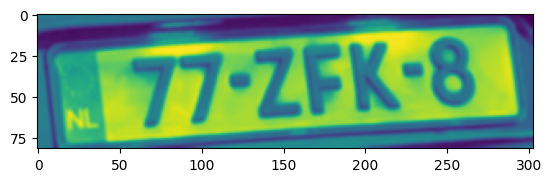

In [25]:
plt.imshow(img_blur)
